## Data Bootcamp Final Project
### Predicting Pitcher Success in Major League Baseball

#### Edward Dearie | Alex Smith

## Abstract

We attempt to address lack of predictive power of the baseline, industry-standard statistics relative to pitching performance year-over-year in Major League Baseball. The primary means of assessing pitcher performance, Earned Run Average, has little correlation with its year-lagged value and thus is not reliable as a forward looking metric. Subsequent attempts to create 'true talent level predictors' (such as FIP, Fielding Independent Pitching) have yielded only marginal improvements in predictive power.  Leveraging the recent release of granular per-pitch and at-bat data by Statcast, we hope to gain further insight into true talent levels.

Using per-pitch data from the 2017 baseball season, we have derived a few predictors that greatly increase the predictive power of pitchers' ERA in the 2018 season.  While we saw a three-fold increase in predictive power from one season to the next, we acknowledge that a great deal of the variance is left unaccounted for.  As such, we present a few of our ideas regarding avenues for continued research.

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from pybaseball import statcast
from pybaseball import pitching_stats_bref
%matplotlib inline

In [130]:
#all csvs below are available in the github drive

teamwin = pd.read_csv('C:/Users/ed745/Documents/Stern Spring 2019 Classes/Data Bootcamp/Project/Teamdata.csv')
teamwin = teamwin.rename(columns={'Wp':'Win_Percentage'})
#this data shows overall team win % and team-level pitching statistics

swing = pd.read_csv('C:/Users/ed745/Documents/Stern Spring 2019 Classes/Data Bootcamp/Project/zone_swing_data.csv')
#this data shows swing and contact data based on pitches inside and outside the strike zone

bref2017 = pd.read_csv('C:/Users/ed745/Documents/Stern Spring 2019 Classes/Data Bootcamp/Project/2017pitching.csv')
bref2018 = pd.read_csv('C:/Users/ed745/Documents/Stern Spring 2019 Classes/Data Bootcamp/Project/2018pitching.csv')
#although the data scrapes we run have a lot of data from baseballreference, it doesn't include everything,
#including metrics such as FIP (Fielding Independent Pitching)

In [131]:
master_pitch2017 = pitching_stats_bref(2017)
master_pitch2018 = pitching_stats_bref(2018)
# do we even need this still??  csv has FIP, ERA+ and potentially all that is here...

In [132]:
master_pitch2018 = master_pitch2018[(master_pitch2018['IP'] >= 30.0)]
master_pitch2017 = master_pitch2017[(master_pitch2017['IP'] >= 30.0)]
#threshold to avoid outlier FIP/ERA pitchers based on small sample size
#for example, a pitcher who only throws 1 inning can have a 27 ERA if they allow 3 runs

In [133]:
master_pitch2018 = master_pitch2018.drop(columns=['Age', 'ERA','#days', 'Lev', 'Tm', 'G', 'GS', 'W', 'L', 'SV', 'IP',
       'H', 'R', 'ER', 'BB', 'SO', 'HR', 'HBP', 'AB', '2B', '3B', 'IBB',
       'GDP', 'SF', 'SB', 'CS', 'PO', 'BF', 'Pit', 'Str', 'StL', 'StS',
       'GB/FB', 'LD', 'PU', 'WHIP', 'BAbip', 'SO9', 'SO/W'])

In [134]:
master_pitch2018 = pd.merge(master_pitch2018, bref2018, on='Name', how='left')

In [135]:
key2017 = pd.DataFrame()
key2018 = pd.DataFrame()

key2017['Name'] = master_pitch2017['Name']
key2018['Name'] = master_pitch2018['Name']

In [136]:
key = pd.merge(key2017, key2018, how='inner', on='Name')
#key pulls the pitchers who exceeded the IP threshold in BOTH 2017 and 2018
#we will use this to filter the 2017 and 2018 databases

In [137]:
test2017 = master_pitch2017
#overall database before filtering for pitchers who also exceeded IP threshold in 2018

In [138]:
test2017 = test2017[test2017['Name'].isin(key['Name'])].sort_values('Name')
#now 2017 database is filtered for pitchers who also exceeded IP threshold in 2018
#sample reduced from 462 pitchers to 321 pitchers

In [139]:
merge2018 = master_pitch2018.drop(columns=['Rk', 'Age', 'Tm', 'Lg', 'W', 'L', 'W-L%', 'G', 'GS',
       'GF', 'CG', 'SHO', 'SV', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'SO',
       'HBP', 'BK', 'WP', 'BF', 'FIP', 'WHIP', 'H9', 'HR9', 'BB9',
       'SO9', 'SO/W'])

In [140]:
merge2018 = merge2018.rename(columns={'ERA':'ERA_2018', 'ERA+':'ERAp2018'})
#ERA+ is a normalized ERA statistic that controls for the league (for example, the American
#League has an extra hitting spot which leads to increased run scoring) as well as park effects
#(in the MLB, each of the 30 stadiums has different dimensions that leads to different amounts
#of runs scored)
#our hypothesis is that it is better to predict ERA+ instead of ERA because we then somewhat 
#neutralize factors outside of the pitcher's control

In [141]:
test2017 = pd.merge(test2017, merge2018, on='Name', how='left')
#bringing in 2018 data for ERA and ERA+ which will be the independent variables we are
#trying to predict with 2017 data

In [142]:
test2017 = test2017.drop(columns=['#days', 'Lev', 'Tm','W', 'L', 'SV','GDP', 'SF', 'SB', 'CS', 'PO'])

In [143]:
test2017 = test2017.rename(columns={'SO/W': 'KBB', 'GB/FB':'GbFb'})
#KBB represents the ratio of the pitcher's strikeouts to walks
#GbFb represents the ratio of the pitcher's generated groundball outs to flyball outs

In [144]:
bref2017 = bref2017.drop(columns=['Rk','Age', 'Tm', 'Lg', 'W', 'L', 'W-L%', 'ERA', 'G', 'GS',
       'GF', 'CG', 'SHO', 'SV', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'SO',
       'HBP', 'BK', 'WP', 'BF','WHIP', 'SO9', 'SO/W'])

In [145]:
test2017 = pd.merge(test2017, bref2017, on='Name', how='left')

## 1. Background

In Major League Baseball (MLB), a team's success is broadly attributable to the strength of its offense, pitching, and fielding. Identifying means to predict true talent levels in each of these three components can therefore generate considerable returns in a team's performance. Hitting talent has long been considered the most easily quantifiable component in baseball, and fielding is the most difficult, leaving pitching as the most analyzed component of baseball performance in the public sphere currently. Pitching is not insignificant - as shown below, in 2018 alone it correlated strongly with team winning percentage with a significant R-squared of 0.767.  Indeed, there somes to be some truth the traditional basesball wisdom that 'pitching wins'.

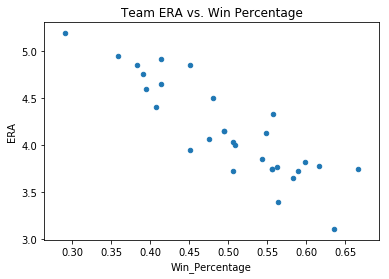

In [146]:
fig, ax = plt.subplots()

teamwin.plot(ax=ax, x='Win_Percentage', y='ERA', title='Team ERA vs. Win Percentage', kind='scatter')

In [147]:
print(smf.ols('Win_Percentage ~ ERA', data=teamwin).fit().summary())

                            OLS Regression Results                            
Dep. Variable:         Win_Percentage   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     92.40
Date:                Thu, 16 May 2019   Prob (F-statistic):           2.28e-10
Time:                        23:16:29   Log-Likelihood:                 51.936
No. Observations:                  30   AIC:                            -99.87
Df Residuals:                      28   BIC:                            -97.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1409      0.067     16.985      0.0

Given pitching's correlation with team success, it is important for MLB teams to assemble teams with the best pitching talent possible, but it is difficult to identify that talent. Earned Run Average (ERA) is a good approximator for a pitcher's on-the-field success because it measures the amount of runs a pitcher allows to be scored on a per-9 inning basis, however, it turns out that an individual pitcher's ERA does not have much predictive power for that pitcher's next year ERA, with an R-squared of 0.038.

In [148]:
print(smf.ols('ERA_2018 ~ ERA', data=test2017).fit().summary())

                            OLS Regression Results                            
Dep. Variable:               ERA_2018   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     12.69
Date:                Thu, 16 May 2019   Prob (F-statistic):           0.000425
Time:                        23:16:32   Log-Likelihood:                -522.59
No. Observations:                 321   AIC:                             1049.
Df Residuals:                     319   BIC:                             1057.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2329      0.233     13.891      0.0

This makes sense - after all, ERA incorporates additional elements outside of the pitcher's direct control, such as the quality of the defense playing behind the pitcher. This problem is well understood in the baseball analytics (sabermetrics) community, and it has led to the creation of statistics that attempt to isolate the pitcher's performance and convert to an ERA-like statistic. One of the most prominent statistics in the public sphere is Fielding Independent Pitching (FIP). It takes the pitcher's strikeouts, walks, and homeruns as inputs to create an ERA that only accounts for plays that are not reliant on the quality of the pitcher's defense. It has long been stated that FIP has more predictive power for a pitcher's true talent level, and while this is likely true to some degree, it turns out that FIP's ability to predict a pitcher's next-year ERA is nearly as limited as ERA, with an R-squared of 0.041.

In [149]:
print(smf.ols('ERA_2018 ~ FIP', data=test2017).fit().summary())

                            OLS Regression Results                            
Dep. Variable:               ERA_2018   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     13.73
Date:                Thu, 16 May 2019   Prob (F-statistic):           0.000249
Time:                        23:16:35   Log-Likelihood:                -522.09
No. Observations:                 321   AIC:                             1048.
Df Residuals:                     319   BIC:                             1056.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9652      0.294     10.082      0.0

Again, this makes sense - while FIP effectively isolates the pitcher's performance from that of the pitcher's defense, it almost completely ignores variables such as the quality of contact that a pitcher allows (the only component of FIP that touches on this is homeruns allowed). If a pitcher has the ability to consistently generate weak contact but does not strikeout a lot of batters, then it stands to reason that the pitcher's ERA is likely to be better than FIP.  As you can see below, FIP is a strong predictor of ERA within the same season with an R-squared of .577 and a correlation coefficient of 0.75. This is not unexpected as the FIP constant is normalized to ERA every year, yet there is still a great deal of variance that is left unexplained.

In [150]:
master_pitch2018.corrwith(master_pitch2018['FIP'])['ERA']

0.7457266624715324

In [151]:
print(smf.ols('ERA ~ FIP', data=test2017).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                    ERA   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     434.4
Date:                Thu, 16 May 2019   Prob (F-statistic):           1.72e-61
Time:                        23:16:41   Log-Likelihood:                -390.51
No. Observations:                 321   AIC:                             785.0
Df Residuals:                     319   BIC:                             792.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0875      0.195      0.448      0.6

## 2. Objective

Our goal is to adress these shortcomings in the following manner:
1. Identify additional variables that are good predictors of a pitcher's next year-ERA and
2. Perform multiple regression model selection to identify the model that best accomplishes predictive ability. Given the aforementioned limitations pertaining to ERA and FIP, implicit within this objective is the aim to leverage statistics that reflect a pitcher's ability to both limit contact and generate weak contact.

## 3. Scope

1. We performed ERA prediction on individual pitchers, not the team.
2. We focused on predicting 2018 results based on 2017 data. The 2019 season is roughly 25% complete so we used the most recent complete-year data in order to increase sample size. We also only focused on one season of data becauses the challenges associated with longitudinal / panel regression analysis are outside the scope of this exploratory study.
3. We limited the analysis to MLB pitchers that pitched at least 30 innings in both 2017 and 2018 to reduce the noise associated with outlier statistics based on small sample sizes.  We arrived at the number of innings after analyzing our sample data.

## 4. Approach

#### Data Gathering

In 2015, the MLB launched an automated tool called Statcast across all thirty MLB stadiums to analyze player movements and athletic abilities in the MLB. Furthermore, the MLB made much of this data publically available through https://baseballsavant.mlb.com/. We sought to gather data from this site as well as prominent sabermetric sites https://www.fangraphs.com/ and https://www.baseball-reference.com/ to inform our analysis.

Due to the exploratory nature of our analysis, we sought to bring in as much data as possible from these three sites and so we installed the python package pybaseball (https://github.com/jldbc/pybaseball) which scrapes the aforementioned sites for their data.

Many statistics are very granular and are on a per-at-bat and per-pitch basis, so much of our data cleaning process focused on aggregating at-bat data grouped by the individual pitcher.

#### Variable Exploration and Model Selection

1. We examined a wide range of variables that reflect different aspects of a pitcher's performance, including pitcher arsenal (e.g., what types of pitches does the pitcher throw, at what velocity, and with what spin rate and movement), batted ball data (e.g., what type of contact did the pitcher yield), and pitching zone data (e.g., what percent of pitches does the pitcher throw for a strike, what percent of pitches do batters swing at, and whether or not contact is made). 
2. After compiling metrics and in some cases calculating rate statistics, we iteratively ran multiple regressions. We identified several models that outperformed FIP and ERA's predictive power, and we iterated on those models until we reached an optimal R-squared.

## 5. Data Gathering

In [19]:
master_data2017 = statcast('2017-04-02', '2017-10-01')
#pulling regular season per pitch per at-bat data

This is a large query, it may take a moment to complete
Completed sub-query from 2017-04-02 to 2017-04-07
Completed sub-query from 2017-04-08 to 2017-04-13
Completed sub-query from 2017-04-14 to 2017-04-19
Completed sub-query from 2017-04-20 to 2017-04-25
Completed sub-query from 2017-04-26 to 2017-05-01
Completed sub-query from 2017-05-02 to 2017-05-07
Completed sub-query from 2017-05-08 to 2017-05-13
Completed sub-query from 2017-05-14 to 2017-05-19
Completed sub-query from 2017-05-20 to 2017-05-25
Completed sub-query from 2017-05-26 to 2017-05-31
Completed sub-query from 2017-06-01 to 2017-06-06
Completed sub-query from 2017-06-07 to 2017-06-12
Completed sub-query from 2017-06-13 to 2017-06-18
Completed sub-query from 2017-06-19 to 2017-06-24
Completed sub-query from 2017-06-25 to 2017-06-30
Completed sub-query from 2017-07-01 to 2017-07-06
Completed sub-query from 2017-07-07 to 2017-07-12
Completed sub-query from 2017-07-13 to 2017-07-18
Completed sub-query from 2017-07-19 to 2017-

In [152]:
statcast2017 = master_data2017

In [153]:
statcast2017 = statcast2017.drop(['description','spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated','des',
       'game_type','home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes','plate_x', 'plate_z','on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id','sz_top', 'sz_bot','game_pk', 'pitcher.1','fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'iso_value','at_bat_number', 'pitch_number', 'pitch_name',
       'home_score', 'away_score', 'bat_score', 'fld_score', 'post_away_score',
       'post_home_score', 'post_bat_score', 'post_fld_score',
       'if_fielding_alignment', 'of_fielding_alignment'], axis=1)
#we dropped varaibles that were not of interest to manage the size of the dataframe

In [154]:
statcast2017 = statcast2017.rename(columns={'player_name':'Name'})

In [155]:
statcast2017 = statcast2017[statcast2017['Name'].isin(key['Name'])]
#we dropped data for all pitches thrown by pitchers that did not pitch at least 30 innings in both seasons

In [156]:
contact = statcast2017.groupby(['Name','launch_speed_angle']).agg({'launch_speed_angle': 'count'})
#launchspeed angle is a new baseball statistic trying to control for the quality of contact that
#hitters generate. The quality of contact goes up as you go from 1 (weak) to 6 (barrel)

In [157]:
contact = contact.unstack(level=-1)
contact.columns = contact.columns.droplevel()

In [158]:
totalcontact = (contact[1.0]+contact[2.0]+contact[3.0]+contact[4.0]+contact[5.0]+contact[6.0])

contact['contactH'] = (contact[5.0]+contact[6.0])/totalcontact
contact['contactS'] = (contact[1.0]+contact[2.0])/totalcontact
contact['contactB'] = contact[6.0]/totalcontact
contact['contactW'] = contact[1.0]/totalcontact
#contactH means hard contact, and levels 5 and 6 correspond to hard contact
#contactS means soft contact, and levls 1 an 2 correspond to soft contact
#contactB means barrel contact, which is level 6 and the highest quality contact
#contactW means weak contact, which is level 1 and the lowest quality contact

In [159]:
contact = contact.reset_index().sort_values('Name')

In [160]:
test2017 = pd.merge(test2017, contact, on='Name', how='left')

In [161]:
test2017 = test2017.rename(columns={1.0:'weak', 2.0:'under', 3.0:'topped', 4.0:'burner', 5.0:'solid', 6.0:'barrel'})

In [162]:
stuff = statcast2017.groupby(['Name', 'pitch_type']).agg({'pitch_type':'count','pfx_x':np.mean, 'pfx_z':np.mean, 'effective_speed':np.mean})
stuff = stuff.sort_values('Name')
#stuff more or less measures the quality of the pitcher's arsenal, by and large referencing
#velocity, movement, and deceptiveness

In [163]:
stuff['abs_pfxx'] = abs(stuff['pfx_x'])
stuff['abs_pfxz'] = abs(stuff['pfx_z'])
#stuff['mov_dist'] = (stuff['pfx_x']**2 + stuff['pfx_z']**2)**(1/2)
#abs_pfxx measures the absolute distance on the horizontal movement of the pitcher's arsenal
#abs_pfxz measures the absolute distance on the vertical movement of the pitcher's arsenal

In [164]:
fast = ['FT', 'FF', 'SI']
slow = ['CU', 'CH', 'SL', 'KC']
#FT is a two-seam fastball, FF is a four-seam fastball, SI is a sinker
#CU is a curveball, CH is a changeup, SL is a slider, KC is a knuckleball

In [165]:
speed = pd.DataFrame()
speed['Name'] = key['Name']
speed = speed.sort_values('Name')
speed['avgFast'] = np.NaN
speed['avgSlow'] = np.NaN
speed = speed.set_index('Name')
#setting up dataframe for pitch speed to determine pitcher level average speeds for
#different pitches within their arsenal, based on 'fast' and 'slow' pitches

In [166]:
for x in speed.index:
    t, r, z, q = 0,0,0,0
    for f in fast:
        if f in (stuff.loc[(x, )].index):
            t += stuff.loc[(x, f), 'pitch_type'] * stuff.loc[(x,f), 'effective_speed']
            r += stuff.loc[(x, f), 'pitch_type']
    speed.loc[x,'avgFast'] = t/r
    for s in slow:
        if s in (stuff.loc[(x, )].index):
            z += stuff.loc[(x, s), 'pitch_type'] * stuff.loc[(x,s), 'effective_speed']
            q += stuff.loc[(x, s), 'pitch_type']
    if q>0:
        speed.loc[x,'avgSlow'] = z/q

#loop structure to get the weighted average speed of pitches defined as fast and slow

In [167]:
speed['dif'] = speed['avgFast'] - speed['avgSlow']
#dif measures the difference in speed between avgFast and avgSlow, a hypothetical proxy for 
#the quality of the pitcher's stuff

In [168]:
test2017 = pd.merge(test2017, speed, on='Name', how='left')

In [169]:
fastball = stuff.drop(columns=['pitch_type','pfx_x', 'pfx_z', ]).reset_index()
fastball = fastball[fastball['pitch_type'] == 'FF'].drop(columns='pitch_type')
fastball = fastball.rename(columns={'effective_speed':'FF_speed', 'abs_pfxx':'FF_pfx_x', 'abs_pfxz':'FF_pfx_z'})
#given the importance of the four-seam fastabll and it's near-universal usage
#isolating individual metrics pertaining to FF because they could have undue influence on the pitcher's results

In [170]:
test2017 = pd.merge(test2017, fastball, how='left', on='Name')

In [171]:
statcast2017['mov_dist'] = (statcast2017['pfx_x']**2 + statcast2017['pfx_z']**2)**(1/2)
statcast2017['abs_pfxx'] = abs(statcast2017['pfx_x'])
#mov_dist measures the pythag theorem of horizontal and vertical movement of the pitcher's arsenal

In [172]:
move = statcast2017.groupby(['Name', 'pitch_type']).agg({'mov_dist':np.mean, 'abs_pfxx':np.mean, 'pitch_type':'count'}).sort_values('Name')

In [173]:
move2 = pd.DataFrame()
move2['Name'] = key['Name']
move2 = move2.sort_values('Name')
move2['avgFastHorMov'] = np.NaN
move2['avgFastTotMov'] = np.NaN
move2 = move2.set_index('Name')
#setting up loop to aggregate average movement statistics at the 'fast' and 'slow' levels
#as opposed to the individual pitch levels, since every pitcher has a different arsenal but
#tends to utilize a 'fast' and a 'slow' pitch

In [174]:
for x in move2.index:
    t,r,z,q=0,0,0,0
    for f in fast:
        if f in move.loc[(x, )].index:
            t += move.loc[(x, f), 'abs_pfxx'] * move.loc[(x, f), 'pitch_type']
            z += move.loc[(x, f), 'mov_dist'] * move.loc[(x, f), 'pitch_type']
            r += move.loc[(x, f), 'pitch_type']
    if r>0:
        move2.loc[x,'avgFastHorMov'] = t/r
        move2.loc[x,'avgFastTotMov'] = z/r
#loop structure to get the weighted averages for both horizontal and 3D movement of fast pitches as baseball
#wisdom suggests that is the sign of a good pitcher.  Movement on slow pitches is a given.

In [175]:
test2017 = pd.merge(test2017, move2, on='Name', how='left')

In [176]:
swing = swing.drop(columns = ['Team', 'IP', 'Swing%', 'O-Contact%','Contact%', 'Pace', 'playerid'])
swing = swing.rename(columns= {'O-Swing%': 'OSwing', 'Z-Swing%':'ZSwing', 'Z-Contact%':'ZContact', 'Zone%':'Zone'})
#OSwing measures the percent of pitches thrown OUTSIDE the strike zone that a batter swings at.
#It can be seen as a proxy for the quality and deceptiveness of the pitcher's stuff.

#ZSwing measures the percent of pitches thrown INSIDE the strike zone that a batter swings at.
#It potentially can signal the pitcher's deceptiveness and ability to command strike zone.

#Zcontact measures the percent of swings within the strike zone that the batter makes contact
#on the ball. It signals the quality of the pitcher's stuff - the lower the Zcontact, the 
#more difficult it is for batters to hit off the pitcher.

In [177]:
test2017 = pd.merge(test2017, swing, on='Name', how='left')

In [178]:
test2017 = test2017.rename(columns={'ERA+':'ERAp'})

In [179]:
tolog = ['WHIP', 'SO9', 'KBB', 'ERA','ERA_2018',
       'ERAp2018', 'ERAp', 'FIP', 'BB9', 'avgFast', 'avgSlow', 'dif', 'FF_speed',
       'FF_pfx_x', 'FF_pfx_z', 'avgFastHorMov', 'avgFastTotMov']
#to improve regression analysis, logging multiple variables that either
#we have reason to believe exhibit a multiplicative-multiplicative relationship
#or that have very different scales

In [180]:
for x in tolog:
    test2017[('ln_' + x)] = np.log(test2017[x])

## 6. Regression Analysis

#### Predictor Variable Selection

We thought it was important to analyze predictor variables that aligned to the following categories:
1. 'Stuff': The most relevant variables for 'Stuff' align to the pitcher's pitch velocity, the velocity differential across their pitch types, the horizontal and/or vertical movement of their various pitches, and the spin rates of those pitches.
2. Batted Ball: The most relevant predictor variables for this category relate to the quality of contact generated by hitters. These include exit velocity of balls put in play and the launch angle of those balls in play. Launch angle is important because a 'peak' angle is one that maximizes expected runs (as defined by FiveThirtyEight in "The New Science of Hitting"). 20-40 degrees is considered the optimal zone to generate high-damage line drives. If the launch angle is too low, the batter is likely to ground out, if it is too high the batter is likely to fly out. A pitcher's deceptiveness and inherent talent can have a great effect on this. 
3. Zone: Pitchers who have high swinging strike percentages that do not result in contact are considered superior. We primarily focused on 2 variables. The first is swinging strike percentage on pitches outside the zone - a pitcher that is able to get batters to swing at balls outside of the strike zone is one that is likely to have more success because it limits the ability of the batter to barrel the ball. The second is in-zone contact percentage - a pitcher that has a low in-zone contact percentage is one that likely has dominant 'stuff' because despite their pitches being in the strike zone, hitters are still unable to catch up.
4. 'Traditional' statistics: In the course of our analysis, we considered several variables such as strikeouts, walks, homeruns, and hits on a per-inning basis as these statistics are thought of as good signals of a pitcher's talent level. Despite this 'common wisdom' hypothesis, it turned out that these variables were not significant predictors of a pitcher's next-year ERA.

#### Dependent Variable Selection

Our initial hypothesis was that the most meaningful dependent variable would be ERA+, which normalizes pitcher ERAs across parks and leagues. This is important because each of the 30 MLB ballparks has very different dimensions and weather conditions, which can either suppress runs scored or bolster them. Additionally, the American League is a higher run-scoring environment than the National League, in part due to talent gaps and in part due to roster construction rule differences, primarily the Designated Hitter.

We achieved meaningful regression results with ERA+ as the dependent variable, however, upon further examination of the regression output, it was clear that there were some oddities in the data. For one, there was a positive relationship between fastball velocity and ERA+. This ran counter to our expectations because we expected that higher fastball velocities should correlate with a lower ERA. We did consider that it is possible that given league-wide multi-year trends in increasing pitcher velocity that this relationship has been somewhat mitigated, but we then noticed another strange positive relationship between O-Swing% (the % of pitches thrown outside the strike zone that the batter swings at) and ERA+. A higher O-Swing% should correlate with a lower ERA because pitches thrown outside the zone are more difficult to hit, and more difficult to hit with authority. Given these two relationships running counter to expectations, we instead chose ERA as the independent variable - doing so resulted in negligible loss in R-squared, improved p-values, and coefficients that aligned to our expectations.

#### Logging Variables

Although we identified meaningful relationships between the predictors and dependent variables, we chose to also log both the predictor and independent variables because 1) we were interested in identifying the multiplicative-multiplicative relationship of predictor variables on the dependent variable as opposed to additive-additive, and 2) the variables we selected had widely varied scales (for example, ERA tends to range from 2.5 to 4.5, whereas fastball velocity tends to range from 88 to 98).

#### Iterative Regression Analysis

There were multiple variables of interest across each of the categories mentioned above in the 'Predictor Variable Selection' paragraph. We tested over 20 individual predictors in single regression analyses, and multiple combinations of these predictors in multiple regression analyses. 

#### Summary of Best Regression Model

Ultimately, four variables were significant predictors: 1) Fastball Velocity, 2) O-Swing%, 3) Z-Contact%, and 4) Strikeouts per 9 innings. After identifying these important variables, we tested multiple combinations with the less meaningful individual predictors to see if we could improve the R-squared and maintain low p-values, but were unable to do so. Ultimately, our best regression was a 3 factor model that used logged fastball velocity, O-Swing%, and logged strikeouts per 9 innings as predictors. The second best model was also of interest, using logged fastball velocity and O-Swing% and Z-Swing% as predictors. We attempted to combine all four predictors in one model, however, this model resulted in multicollinearity so we are more comfortable proceeding with the two models separated. The results for these two models are shown below.

In [181]:
print(smf.ols('ln_ERA_2018 ~ ln_FF_speed + OSwing + ln_SO9', data=test2017).fit().summary())

                            OLS Regression Results                            
Dep. Variable:            ln_ERA_2018   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     16.86
Date:                Thu, 16 May 2019   Prob (F-statistic):           4.16e-10
Time:                        23:17:26   Log-Likelihood:                -73.051
No. Observations:                 289   AIC:                             154.1
Df Residuals:                     285   BIC:                             168.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      13.6708      3.364      4.064      

In [182]:
print(smf.ols('ln_ERA_2018 ~ ln_FF_speed + OSwing + ZContact', data=test2017).fit().summary())

                            OLS Regression Results                            
Dep. Variable:            ln_ERA_2018   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     15.54
Date:                Thu, 16 May 2019   Prob (F-statistic):           2.18e-09
Time:                        23:17:29   Log-Likelihood:                -74.764
No. Observations:                 289   AIC:                             157.5
Df Residuals:                     285   BIC:                             172.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      13.7868      3.505      3.934      

## 7. Conclusion

#### Key Takeaways

We believe our multiple regression model is a very meaningful predictor for a pitcher's next-year ERA. Considering that both prior year FIP (considered the baseline industry standard for predicting pitcher performance) and ERA account for ~4% of the variance around the mean of next-year ERA, we believe that our model is a very useful predictor, accounting for ~15% of the variance around the mean for next-year ERA.

While 15% may seem to be a low R-squared in different environments, we believe that the nature of the sport and pitcher performance in general are such that it would be difficult to build a one-year model of factors within a pitcher's control that can out-perform 15% with publically available data. For example, the quality of defense behind the pitcher can grossly inflate the pitcher's ERA regardless of that pitcher's talent level. Additionally, quality of opposition has a large impact on ERA (e.g., a pitcher facing the World Series winning Red Sox between 5 and 10 times per season will likely suffer a degradation in ERA). 

Furthermore, the factors in our model have a 30% R-squared for predicting logged same-season ERA - this shows that they are crucial factors in pitcher performance. This is particularly interesting because same-season ERA predicts ~4% of the variance around the mean for next-season ERA, and we were able to extract elements that amount to predicting 30% of same-season ERA and generate improved prediction of next-season ERA.

#### A Way Forward

The model we built has potential applications for pitcher evaluation in Major League Baseball. First and foremost, this can serve as the foundation for conducting a multi-year longitudinal regression analysis that would help generate even more insights based on a larger dataset. We were able to predict 2018 performance to a reasonable degree based on 2017 data - it would be interesting to see how this analysis holds up in a multi-year time series regression.

Finally, this model potentially serves as a foundation for development of another FIP-like metric, based on different input variables. Achieving a multi-year longitudinal regression would help to identify the appropriate coefficients and weights to assign to the variables we selected, which in turn would be used to create an improved version of the baseline industry standard FIP.

## 8. Appendix - Regression Analyses

An example of our models using logged ERA+ as the dependent variables follows.  They were ultimately thrown out for aforementioned reasons.  We believe that biases in constructing the ERA+ metric may be the root cause.

In [183]:
print(smf.ols('ln_ERAp2018 ~ ln_FF_speed + OSwing + ln_SO9', data=test2017).fit().summary())

                            OLS Regression Results                            
Dep. Variable:            ln_ERAp2018   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     17.36
Date:                Thu, 16 May 2019   Prob (F-statistic):           2.23e-10
Time:                        23:17:35   Log-Likelihood:                -70.471
No. Observations:                 289   AIC:                             148.9
Df Residuals:                     285   BIC:                             163.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -7.9811      3.334     -2.394      

In [184]:
print(smf.ols('ln_ERAp2018 ~ ln_FF_speed + OSwing + ZContact', data=test2017).fit().summary())

                            OLS Regression Results                            
Dep. Variable:            ln_ERAp2018   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     15.90
Date:                Thu, 16 May 2019   Prob (F-statistic):           1.37e-09
Time:                        23:17:37   Log-Likelihood:                -72.352
No. Observations:                 289   AIC:                             152.7
Df Residuals:                     285   BIC:                             167.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -8.2771      3.476     -2.381      

We had concerns regarding multicollinearity in our final models, specifically regarding covariance between the percent of pitches swung at outside the strike zone and strike outs.  We believe the correlation of OSwing with both the log of strike-outs per nine innings and the actual strike-outs per nine innings, as shown below, puts those concerns to rest.

In [185]:
test2017.corrwith(test2017['ln_SO9'])['OSwing']

0.13890722224949403

In [186]:
test2017.corrwith(test2017['SO9'])['OSwing']

0.15181979679275082

## Sources

The following sources and previous research were consulted in defining our problem and refining our approach.

FiveThirtyEight, "The New Science of Hitting" (https://fivethirtyeight.com/features/the-new-science-of-hitting/; https://github.com/jldbc/pybaseball/blob/master/EXAMPLES/fivethirtyeight_new_science_of_hitting.ipynb)

Pitcher List, "Going Deep: The Relative Value of FIP, xFIP and SIERA" (https://www.pitcherlist.com/going-deep-the-relative-value-of-fip-xfip-and-siera/)

The Hardball Times, "Pitch Movement, Spin Efficiency, and All That," by Alan Nathan, August 27, 2018 (https://tht.fangraphs.com/pitch-movement-spin-efficiency-and-all-that/)

Documentation on the pybaseball package v1.0.4 is available at: https://github.com/jldbc/pybaseball